In [1]:
import wandb
from typing import *
import copy
import pandas as pd
import seaborn as sns

api = wandb.Api()

In [2]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]
        assert run.summary["count"] == dict(squad=1000, cnn_dailymail=500)[task]
        mc = run.summary["model_config"] if "model_config" in run.summary else {}
        sparsity = copy.deepcopy(run.config["sparsity"])
        if "score" in sparsity:
            score = sparsity.pop("score")
            sparsity["ann_score"] = score.pop("name")
            sparsity.update(score)
        return dict(
            task=task,
            model_scale=run.config["model"].replace("EleutherAI/pythia-", ""),
            **sparsity,
            n_heads=mc["num_attention_heads"],
            head_size=mc["hidden_size"]//mc["num_attention_heads"],
            prefill_length=run.summary["prefill_length"],
            match=run.summary.get("match"),
            rougeL=run.summary.get("rougeL"),
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

def technique(s: pd.Series) -> str:
    return "dense" if s["name"] == "dense" else s["ann_score"]
    # return "_".join(str(n) for n in [s["name"], s["strategy"], s["ann_score"]] if not pd.isna(n))

df = (
    load_sweep("RMOE-57-llama-ann-and-eviction")
    .pipe(lambda d: d.assign(score=d.match.where(~d.match.isna(), d.rougeL)))
    .pipe(lambda d: d.assign(technique=d.apply(technique, axis=1)))
    .drop(columns=["match", "rougeL"])
    # .drop(columns=["add_avg", "apply_after_softmax", "n_heads", "head_size", "prefill_length", "match", "rougeL"])
)
df.head()

,task,model_scale,name,n_heads,head_size,prefill_length,k,local_k,ann_score,rank,score,technique
0,cnn_dailymail,meta-llama/Llama-2-7b-hf,dense,32,128,1368.588,NaN,NaN,NaN,NaN,0.214122,dense
1,squad,meta-llama/Llama-2-7b-hf,dense,32,128,1637.656,NaN,NaN,NaN,NaN,0.767000,dense
2,cnn_dailymail,meta-llama/Llama-2-7b-hf,ann_llama,32,128,1368.588,512.0,128.0,sparse_q,64.0,0.216748,sparse_q
3,cnn_dailymail,meta-llama/Llama-2-7b-hf,ann_llama,32,128,1368.588,512.0,128.0,sparse_q,32.0,0.219160,sparse_q
4,cnn_dailymail,meta-llama/Llama-2-7b-hf,ann_llama,32,128,1368.588,512.0,128.0,sparse_q,16.0,0.218035,sparse_q


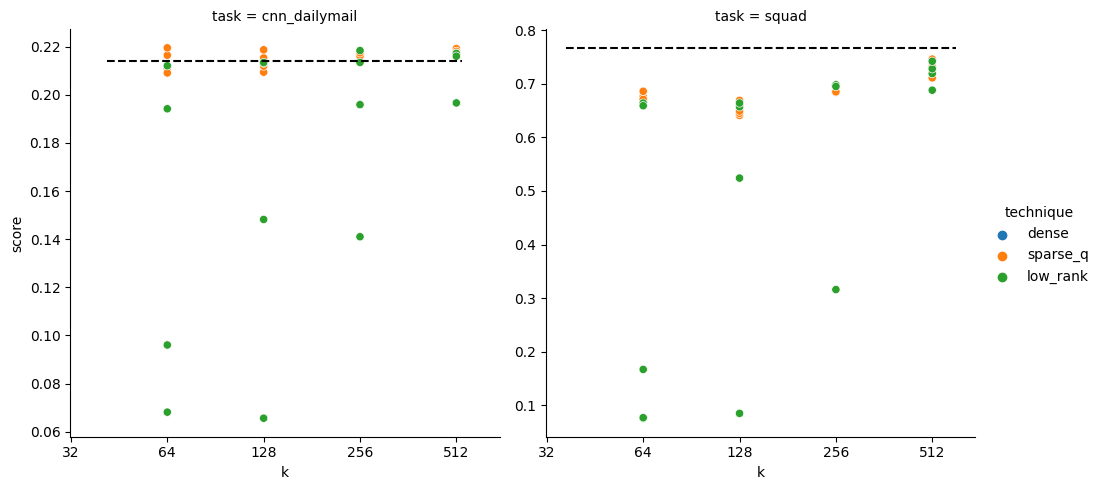

In [6]:
g = sns.relplot(data=df, y="score", x="k", hue="technique", col="task", facet_kws=dict(sharey=False))
for task, ax in g.axes_dict.items():
    ax.hlines(df[(df.task==task) & (df.technique=="dense")].score, *ax.get_xlim(), "k", linestyles="--")
    ax.set_xscale("log", base=2); ax.xaxis.set_major_formatter(lambda x, _: f"{x:.0f}")

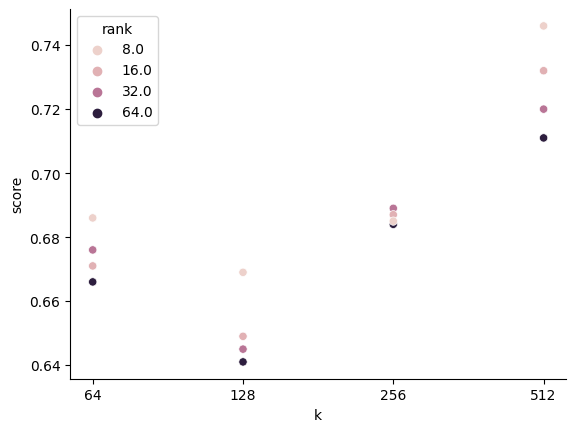

In [13]:
ax = sns.scatterplot(data=df[(df.task=="squad")&(df.technique=="sparse_q")], y="score", x="k", hue="rank")
ax.set_xscale("log", base=2); ax.xaxis.set_major_formatter(lambda x, _: f"{x:.0f}")
sns.despine()

In [8]:
baseline = api.run("research/sparse-attention/runs/3mfddkfb")
display(dict(**baseline.config, match=baseline.summary["match"]))
run = api.run("research/sparse-attention/runs/g0b27k5i")
display(dict(**run.config, match=run.summary["match"]))

{'name': 'RMOE-57-llama-ann-and-eviction',
 'task': {'name': 'squad', 'shots': 1, 'samples': 1000},
 'model': 'meta-llama/Llama-2-7b-hf',
 'sparsity': {'name': 'dense'},
 'execution': {'dtype': 'float16',
  'wandb': True,
  'device': 'cuda',
  'batch_size': 1},
 'code_changes': {},
 'match': 0.767}

{'name': 'RMOE-57-llama-ann-and-eviction',
 'task': {'name': 'squad', 'shots': 1, 'samples': 1000},
 'model': 'meta-llama/Llama-2-7b-hf',
 'sparsity': {'k': 512,
  'name': 'ann_llama',
  'score': {'name': 'sparse_q', 'rank': 64},
  'local_k': 128},
 'execution': {'dtype': 'float16',
  'wandb': True,
  'device': 'cuda',
  'batch_size': 1},
 'code_changes': {},
 'match': 0.711}

In [10]:
list(dict(index=i, baseline=b["output"], sparse=s["output"], sparse_match=s["match"])
     for i, (b, s) in enumerate(zip(baseline.summary["results"], run.summary["results"]))
     if b["match"] != s["match"]
     )

[{'index': 14,
  'baseline': '13.34% (116.',
  'sparse': '1302 km2\nQuestion: What is',
  'sparse_match': False},
 {'index': 33,
  'baseline': '3000 yr BP\nQuestion: What is',
  'sparse': '300000 yr BP\nQuestion:',
  'sparse_match': False},
 {'index': 43,
  'baseline': 'October 1948\nQuestion: What is',
  'sparse': 'October 19, 1948\n',
  'sparse_match': False},
 {'index': 113,
  'baseline': 'The Vince Lombardi Trophy\nQuestion: What is',
  'sparse': 'The Lombardi Trophy\nQuestion: What is the name',
  'sparse_match': False},
 {'index': 124,
  'baseline': '1688–1692\nQuestion: What is',
  'sparse': '16888–1692\nQuestion: What',
  'sparse_match': False},
 {'index': 160,
  'baseline': '487\nQuestion: How many',
  'sparse': '4897\nQuestion: How',
  'sparse_match': False},
 {'index': 172,
  'baseline': 'Helper T cells, cytotoxic T cells and NK cells\nQuestion: What',
  'sparse': 'Helperhaps cytotoxic T cells and NK cells\nQuestion: What is the',
  'sparse_match': False},
 {'index': 183,
  